# NN Backpropagation
Created by Quan on 2019/2/8.  

In [488]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import scipy.io as sio
import scipy.optimize as opt
from sklearn.metrics import classification_report

In [489]:
data = sio.loadmat('ex4data1')
X = data.get('X')
# transpose
X = np.array([image.reshape(20, 20).T.reshape(-1) for image in X])
y = data.get('y').reshape(-1)

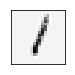

In [490]:
pick_one = np.random.randint(0, 5000)
fig, ax = plt.subplots(figsize=(1, 1))
ax.matshow(X[pick_one, :].reshape(20, -1), cmap=matplotlib.cm.binary)
plt.xticks(np.array([]))
plt.yticks(np.array([]))
plt.show()

In [491]:
def plot_100_images(X):
    # X:(5000, 400)
    size = int(np.sqrt(X.shape[1]))
    
    sample_idx = np.random.choice(X.shape[0], 100)
    sample_image = X[sample_idx, :]
    fig, ax_array = plt.subplots(10, 10, sharex=True, sharey=True, figsize=(8, 8))
    for r in range(10):
        for c in range(10):
            ax_array[r, c].matshow(sample_image[10 * r + c].reshape(size, size), cmap=matplotlib.cm.binary)
    plt.xticks(np.array([]))
    plt.yticks(np.array([]))

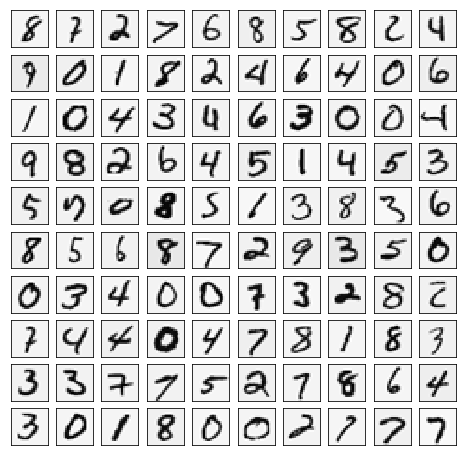

In [492]:
plot_100_images(X)
plt.show()

## 神经网络模型

## 读取权重

In [493]:
#隐藏层有25个神经元
data = sio.loadmat('ex4weights')
theta1, theta2 = data.get('Theta1'), data.get('Theta2')
theta1.shape, theta2.shape

((25, 401), (10, 26))

In [494]:
#theta是根据原来数据训练的，需要获取未被转置的数据
data = sio.loadmat('ex4data1')
X, y = data.get('X'), data.get('y').reshape(-1)
X.shape, y.shape

((5000, 400), (5000,))

In [495]:
X = np.insert(X, 0, 1, axis=1)
X

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.]])

In [496]:
new_y = []
for k in range(1, 11):
    new_y.append((y == k).astype(int))
y = np.array(new_y).T

In [497]:
y.shape

(5000, 10)

## 前向传播

In [498]:
def serialize(t1, t2):
    return np.concatenate((t1.reshape(-1), t2.reshape(-1)))

In [499]:
def deserialize(theta):
    # theta1: 25*401, theta2: 10*26
    return theta[:25 * 401].reshape(25, 401), theta[25 * 401:].reshape(10, 26)

In [500]:
def feedforward(theta, X):
    a1 = X
    
    theta1, theta2 = deserialize(theta)
    
    # X: 5000*401, theta1: 25*401
    z2 = X @ theta1.T
    a2 = np.insert(sigmoid(z2), 0, 1, axis=1)
    
    # a2: 5000*26, theta2: 10*26
    z3 = a2 @ theta2.T
    a3 = sigmoid(z3)
    
    return a1, z2, a2, z3, a3

In [501]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

In [502]:
theta = serialize(theta1, theta2)

In [503]:
_, _, _, _, h = feedforward(theta, X)
h

array([[1.12661530e-04, 1.74127856e-03, 2.52696959e-03, ...,
        4.01468105e-04, 6.48072305e-03, 9.95734012e-01],
       [4.79026796e-04, 2.41495958e-03, 3.44755685e-03, ...,
        2.39107046e-03, 1.97025086e-03, 9.95696931e-01],
       [8.85702310e-05, 3.24266731e-03, 2.55419797e-02, ...,
        6.22892325e-02, 5.49803551e-03, 9.28008397e-01],
       ...,
       [5.17641791e-02, 3.81715020e-03, 2.96297510e-02, ...,
        2.15667361e-03, 6.49826950e-01, 2.42384687e-05],
       [8.30631310e-04, 6.22003774e-04, 3.14518512e-04, ...,
        1.19366192e-02, 9.71410499e-01, 2.06173648e-04],
       [4.81465717e-05, 4.58821829e-04, 2.15146201e-05, ...,
        5.73434571e-03, 6.96288990e-01, 8.18576980e-02]])

## 代价函数

In [504]:
def cost(theta, X, y):
    m = len(X)
    
    _, _, _, _, h = feedforward(theta, X)
    J = (-1 / m) * np.sum((y * np.log(h)) + (1 - y) * (np.log(1 - h)))
    return J

In [505]:
cost(theta, X, y)

0.2876291651613189

## 正则化代价函数

In [506]:
def regularized_cost(theta, X, y, l=1):
    m = len(X)
    
    theta1, theta2 = deserialize(theta)
    
    reg_term1 = l / (2 * m) * np.sum(theta1[:, 1:] ** 2)
    reg_term2 = l / (2 * m) * np.sum(theta2[:, 1:] ** 2)
    return cost(theta, X, y) + reg_term1 + reg_term2

In [507]:
regularized_cost(theta, X, y)

0.38376985909092365

## 反向传播

## sigmoid梯度

In [508]:
def sigmoid_gradient(z):
    return sigmoid(z) * (1 - sigmoid(z))

## 随机初始化

In [509]:
# sqrt(6) / sqrt(401 + 25) ≈ 0.12
theta1 = np.random.uniform(-0.12, 0.12, (25, 401))

# sqrt(6) / sqrt(26 + 10) ≈ 0.41
theta2 = np.random.uniform(-0.41, 0.41, (10, 26))

theta1.shape, theta2.shape

((25, 401), (10, 26))

In [510]:
theta = serialize(theta1, theta2)

## 梯度

In [511]:
def gradient(theta, X, y):
    
    theta1, theta2 = deserialize(theta)
    m = len(X)
    
    delta1 = np.zeros(theta1.shape)  # (25, 401)
    delta2 = np.zeros(theta2.shape)  # (10, 26)
    
    a1, z2, a2, z3, a3 = feedforward(theta, X)
    
    for i in range(m):
        i_a1 = a1[i, :]  # (401,)
        i_z2 = z2[i, :]  # (25,)
        i_a2 = a2[i, :]  # (26,)
        i_z3 = z3[i, :]  # (10,)
        i_a3 = a3[i, :]  # (10,)
        
        # y: 5000*10
        i_d3 = i_a3 - y[i, :]  # (10,)
        
        i_d2 = theta2.T @ i_d3 * (i_a2 * (1 - i_a2))  # (26,)
        i_d1 = theta1.T @ i_d2[1:] * (i_a1 * (1 - i_a1))  # (401,)
        
        # (25, 401)
        delta1 += i_d2[1:].reshape(-1, 1) @ i_a1.reshape(1, -1)
        # (10, 26)
        delta2 += i_d3.reshape(-1, 1) @ i_a2.reshape(1, -1)
        
    delta2 /= m
    delta1 /= m
    
    return serialize(delta1, delta2)

In [512]:
d1, d2 = deserialize(gradient(theta, X, y))
d1.shape, d2.shape

((25, 401), (10, 26))

## 梯度检测

In [513]:
def gradient_checking(theta, X, y, epsilon, regularized=False):
    print('Executing...')
    def a_numeric_gradient(plus, minus, regularized=False):
        if regularized:
            return (regularized_cost(plus, X, y) - regularized_cost(minus, X, y)) / (2 * epsilon)
        else:
            return (cost(plus, X, y) - cost(minus, X, y)) / (2 * epsilon)
        
    theta_matrix = expand_array(theta)
    epsilon_matrix = np.identity(len(theta)) * epsilon
    
    plus_matrix = theta_matrix + epsilon_matrix
    minus_matrix = theta_matrix - epsilon_matrix
    
    numeric_grad = np.array([a_numeric_gradient(plus_matrix[i], minus_matrix[i], regularized) for i in range(len(theta))])
    
    nn_grad = regularized_gradient(theta, X, y) if regularized else gradient(theta, X, y)
    
    # https://en.wikipedia.org/wiki/Relative_change_and_difference
    relative_diff = np.linalg.norm(numeric_grad - nn_grad) / np.linalg.norm(numeric_grad + nn_grad)
    
    print('If your backpropagation implementation is correct,\nthe relative difference will be smaller than 1e-9 (assume epsilon=0.0001).\nRelative Difference: {}'.format(relative_diff))

In [514]:
def expand_array(arr):
    return arr * np.ones((len(arr), 1))

In [515]:
# 运行很慢，可能需要几分钟
# gradient_checking(theta, X, y, epsilon=0.0001)

## 正则化神经网络

In [516]:
def regularized_gradient(theta, X, y, l=1):
    m = len(X)
    d1, d2 = deserialize(gradient(theta, X, y))
    t1, t2 = deserialize(theta)
    
    t1[:, 0] = 0
    t2[:, 0] = 0
    
    d1 += (l / m) * t1
    d2 += (l / m) * t2
    
    return serialize(d1, d2)

In [517]:
# 运行很慢，可能需要几分钟
# gradient_checking(theta, X, y, epsilon=0.0001, regularized=True)

## 训练模型

In [518]:
res = opt.minimize(fun=regularized_cost,
                   x0=theta,
                   args=(X, y, 1),
                   method='Newton-CG',
                   jac=regularized_gradient,
                   options={'maxiter': 1500}
                  )
res

     fun: 0.3616191321184111
     jac: array([-4.19526240e-03,  6.94105437e-06, -1.85234639e-06, ...,
        1.04633061e-03,  1.03130904e-03,  1.23160983e-03])
 message: 'Warning: Desired error not necessarily achieved due to precision loss.'
    nfev: 48
    nhev: 0
     nit: 26
    njev: 466
  status: 2
 success: False
       x: array([ 0.        ,  0.03470527, -0.00926173, ..., -2.76479688,
       -1.29325451, -1.7667281 ])

In [519]:
final_theta = res.x

In [520]:
data = sio.loadmat('ex4data1')
y_answer = data.get('y').reshape(-1)

In [521]:
def show_accuracy(theta, X, y):
    _, _, _, _, h = feedforward(theta, X)
    y_pred = np.argmax(h, axis=1) + 1
    
    print('accuracy: {}%'.format(np.mean(y_pred == y) * 100))

In [522]:
show_accuracy(final_theta, X, y_answer)

accuracy: 98.16%


## 显示隐藏层

In [523]:
def plot_hidden_units(theta):
    final_theta1, _ = deserialize(theta)
    hidden_layer = final_theta1[:, 1:]
    
    fig, ax_array = plt.subplots(5, 5, sharex=True, sharey=True, figsize=(5, 5))
    for r in range(5):
        for c in range(5):
            ax_array[r, c].matshow(hidden_layer[r * 5 + c].reshape(20, 20), cmap=matplotlib.cm.binary)
    plt.xticks(np.array([]))
    plt.yticks(np.array([]))

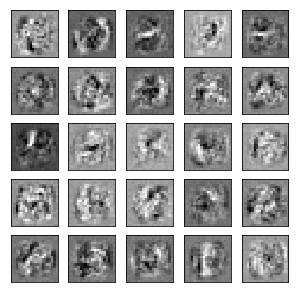

In [524]:
plot_hidden_units(final_theta)
plt.show()